## Learning is just parameter estimation

In [1]:
import torch

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
t_c.shape

torch.Size([11])

In [4]:
# Simplest model

#t_c = w*t_u + b

In [59]:
def model(t_u,w,b):
  return w*t_u + b

In [6]:
def loss_fn(t_p,t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [7]:
w = torch.ones(())
b = torch.zeros(())

In [8]:
t_p = model(t_u,w,b)

In [9]:
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [10]:
loss = loss_fn(t_p,t_c)
loss

tensor(1763.8848)

Broadcasting, which is popular in NumPy and adapted by PyTorch, relaxes this assumption for most binary operations. It uses the following rules to match tensor elements:


 For each index dimension, counted from the back, if one of the operands is
size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension


If both sizes are greater than 1, they must be the same, and natural matching
is used.

If one of the tensors has more index dimensions than the other, the entirety
of the other tensor will be used for each entry along these dimensions.

In [11]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

In [12]:
print(f"shapes: x: {x.shape}, y: {y.shape}")

shapes: x: torch.Size([]), y: torch.Size([3, 1])


In [13]:
print(f" z: {z.shape}, a: {a.shape}")

 z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


In [14]:
print("x * y:", (x * y).shape) #Rule 3 of borad casting is used here

x * y: torch.Size([3, 1])


In [15]:
print("y * z:", (y * z).shape) # Rule 2 will be used

y * z: torch.Size([3, 3])


In [16]:
print("y * z * a:", (y * z * a).shape) # Rule 1 is used here

y * z * a: torch.Size([2, 3, 3])


In [17]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [18]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [19]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

In [20]:
b = b - learning_rate * loss_rate_of_change_b

In [21]:
w

tensor(-44.1730)

In [22]:
b

tensor(46.)

In [23]:
def dloss_fn(t_p,t_c):
  dsq_diffs = 2*(t_p - t_c)/t_p.size(0)
  return dsq_diffs

In [24]:
def dmodel_dw(t_u,w,b):
  return t_u

In [25]:
def dmodel_db(t_u,w,b):
  return 1.0

In [26]:
def grad_fn(t_u,t_c,t_p,w,b):
  dloss_dtp = dloss_fn(t_p,t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u,w,b)
  dloss_db = dloss_dtp * dmodel_db(t_u,w,b)
  return torch.stack([dloss_dw.sum(),dloss_db.sum()])

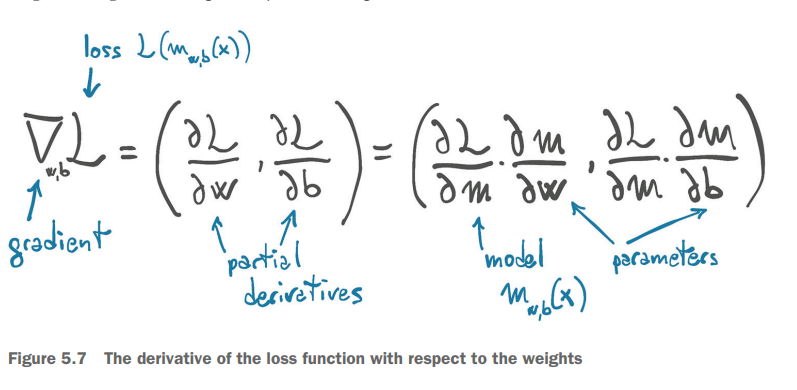

In [27]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1,n_epochs+1):
    t_p = model(t_u,w,b)
    loss = loss_fn(t_p,t_c)
    grad = grad_fn(t_u,t_c,t_p,w,b)
    params = params - learning_rate*grad
    print('Epoch %d, Loss %f' %(epoch,float(loss)))
  return params

In [35]:
def training_loop_param(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad   # Not in place

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [29]:
training_loop_param(
    n_epochs = 100,
    learning_rate=1e-2,
    params = torch.tensor([1,0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [30]:
training_loop_param(
    n_epochs = 100,
    learning_rate=1e-4,
    params = torch.tensor([1,0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [31]:
# Normalizing the inputs
t_un = 0.1 * t_u

In [32]:
training_loop_param(
    n_epochs = 100,
    learning_rate=1e-2,
    params = torch.tensor([1,0]),
    t_u = t_un,
    t_c = t_c
)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

NOTE The normalization here absolutely helps get the network trained, but
you could make an argument that it’s not strictly needed to optimize the
parameters for this particular problem. That’s absolutely true! This problem is
small enough that there are numerous ways to beat the parameters into submission. However, for larger, more sophisticated problems, normalization is an
easy and effective (if not crucial!) tool to use to improve model convergence.

In [36]:
params = training_loop_param(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c,
print_params = False)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


In [37]:
params

tensor([  5.3671, -17.3012])

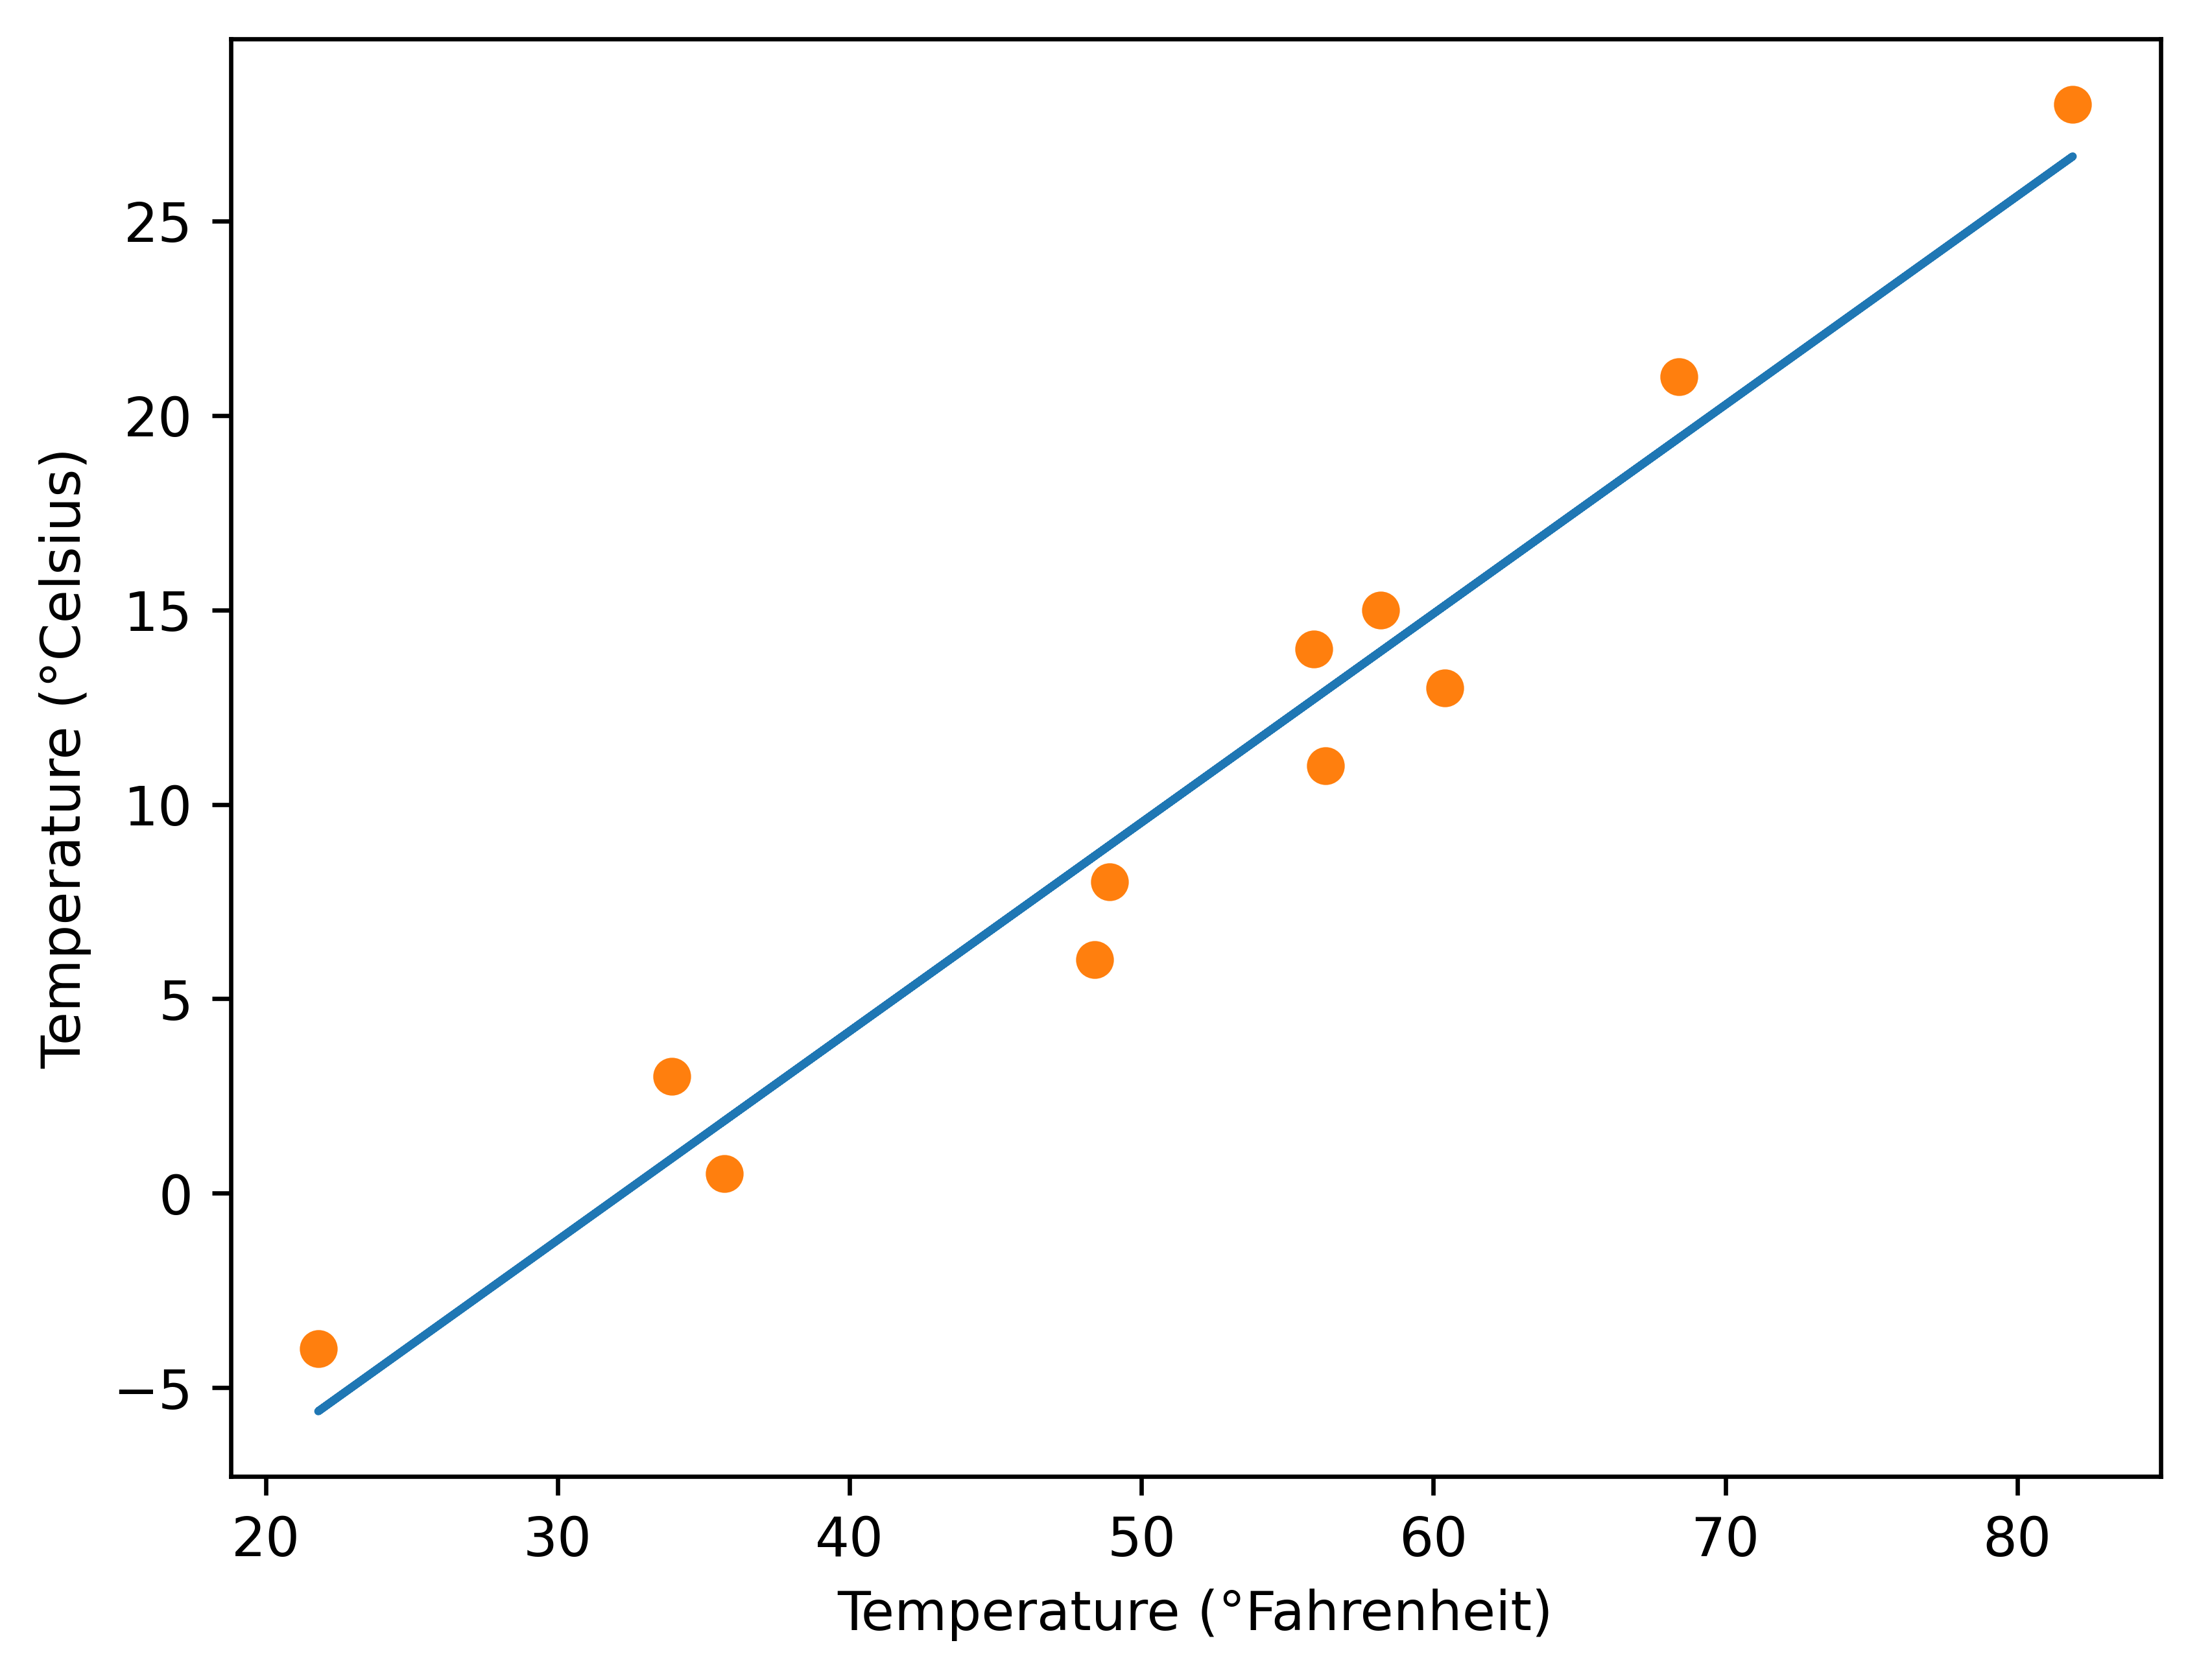

In [38]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We are using a Python trick called argument unpacking here: *params means to pass the
elements of params as individual arguments. In Python, this is usually done with lists
or tuples, but we can also use argument unpacking with PyTorch tensors, which are
split along the leading dimension. So here, model(t_un, *params) is equivalent to
model(t_un, params[0], params[1]).

## Computing the gradient automatically

This is when PyTorch tensors come to the rescue, with a PyTorch component called
autograd. Chapter 3 presented a comprehensive overview of what tensors are and what
functions we can call on them. We left out one very interesting aspect, however:
PyTorch tensors can remember where they come from, in terms of the operations and
parent tensors that originated them, and they can automatically provide the chain of
derivatives of such operations with respect to their inputs. This means we won’t need
to derive our model by hand;10 given a forward expression, no matter how nested,
PyTorch will automatically provide the gradient of that expression with respect to its
input parameters.

Autograd

In [39]:
params = torch.tensor([1.0,0.0], requires_grad=True)

Notice the requires_grad=True argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on params. In other words, any tensor that will have params as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
params tensor.

In [40]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with requires_grad set to
True, then call the model and compute the loss, and then call backward on the loss
tensor:

In [41]:
loss = loss_fn(model(t_u,*params),t_c) # param[0],param[1]
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

At this point, the grad attribute of params contains the derivatives of the loss with
respect to each element of params.
 When we compute our loss while the parameters w and b require gradients, in
addition to performing the actual computation, PyTorch creates the autograd graph
with the operations (in black circles) as nodes, as shown in the top row of figure 5.10. When we call loss.backward(), PyTorch traverses this graph in the reverse
direction to compute the gradients, as shown by the arrows in the bottom row of
the figure.

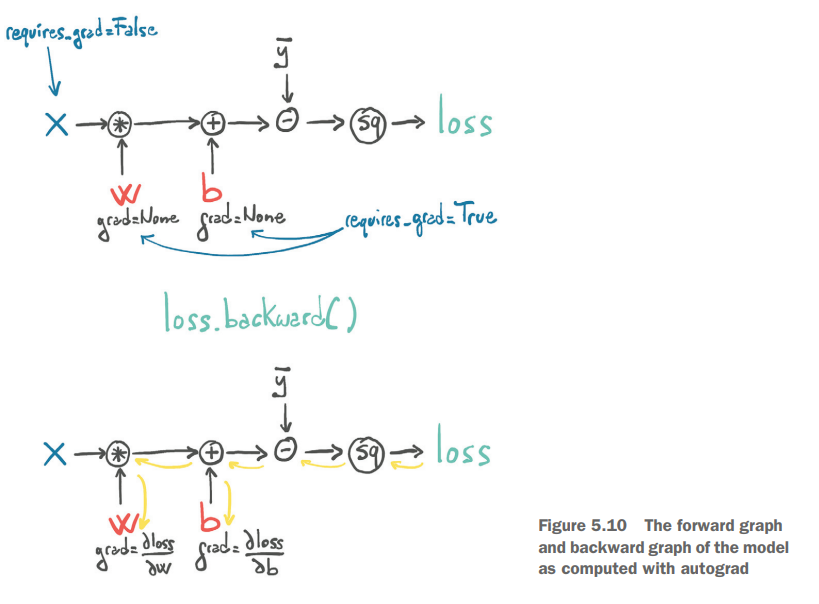

ACCUMULATING GRAD FUNCTIONS
We could have any number of tensors with requires_grad set to True and any composition of functions. In this case, PyTorch would compute the derivatives of the loss
throughout the chain of functions (the computation graph) and accumulate their values in the grad attribute of those tensors (the leaf nodes of the graph).
 Alert! Big gotcha ahead. This is something PyTorch newcomers—and a lot of more
experienced folks, too—trip up on regularly. We just wrote accumulate, not store.
WARNING Calling backward will lead derivatives to accumulate at leaf nodes.
We need to zero the gradient explicitly after using it for parameter updates.
Let’s repeat together: calling backward will lead derivatives to accumulate at leaf nodes.
So if backward was called earlier, the loss is evaluated again, backward is called again
(as in any training loop), and the gradient at each leaf is accumulated (that is,
summed) on top of the one computed at the previous iteration, which leads to an
incorrect value for the gradient.
 In order to prevent this from occurring, we need to zero the gradient explicitly at each
iteration. We can do this easily using the in-place zero_ method:

In [42]:
if params.grad is not None:
  params.grad.zero_()

In [43]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()

    t_p = model(t_u,*params)
    loss = loss_fn(t_p,t_c)
    loss.backward()

    with torch.no_grad():
      params -= learning_rate*params.grad   # In place

    if epoch%500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))

  return params

In [44]:
training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0], requires_grad=True),
t_u = t_un,
t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers a la carte

he torch
module has an optim submodule where we can find classes implementing different
optimization algorithms.

In [69]:
import torch.optim as optim

In [46]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_adafactor',
 '_functional',
 'lr_scheduler',
 'swa_utils']

Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically
with requires_grad set to True) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their grad attribute, as represented in figure 5.11

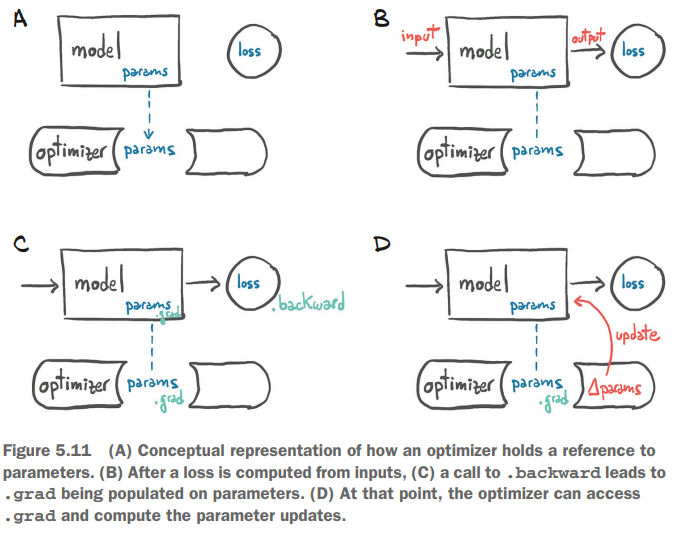

Each optimizer exposes two methods: zero_grad and step. zero_grad zeroes the
grad attribute of all the parameters passed to the optimizer upon construction. step
updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

In [47]:
params = torch.tensor([1.0,0.0],requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params],lr=learning_rate)

Here SGD stands for stochastic gradient descent. Actually, the optimizer itself is exactly a
vanilla gradient descent (as long as the momentum argument is set to 0.0, which is the
default). The term stochastic comes from the fact that the gradient is typically obtained
by averaging over a random subset of all input samples, called a minibatch. However, the
optimizer does not know if the loss was evaluated on all the samples (vanilla) or a random subset of them (stochastic), so the algorithm is literally the same in the two cases.

In [48]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u,*params)
loss = loss_fn(t_p,t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([-44.1730,  -0.8260], requires_grad=True)

In [49]:
def training_loop(n_epochs,optimizer,params,t_u,t_c):
    for epoch in range(1,n_epochs+1):
      t_p = model(t_u,*params)
      loss = loss_fn(t_p,t_c)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % 500 == 0:
        print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [50]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
n_epochs = 5000,
optimizer = optimizer,
params = params,
t_u = t_un,
t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [51]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(
n_epochs = 2000,
optimizer = optimizer,
params = params,
t_u = t_u,
t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086698
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

## Training, validation, and overfitting

Generalization Error and randperm

In [52]:
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices,val_indices

(tensor([10,  9,  4,  3,  6,  2,  5,  1,  0]), tensor([7, 8]))

In [53]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [54]:
train_t_un = 0.1*train_t_u
val_t_un = 0.1*val_t_u

In [66]:
def training_loop(n_epochs,optimizer,params,train_t_u,val_t_u,train_t_c,val_t_c):
    for epoch in range(1,n_epochs+1):
      train_t_p = model(train_t_u,*params)
      train_loss = loss_fn(train_t_p,train_t_c)

      val_t_p = model(val_t_u,*params)
      val_loss = loss_fn(val_t_p,val_t_c)

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      if epoch <= 3 or epoch % 500 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
              f" Validation loss {val_loss.item():.4f}")
    return params

In [71]:
params = torch.tensor([1.0,0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params],lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'Tensor'

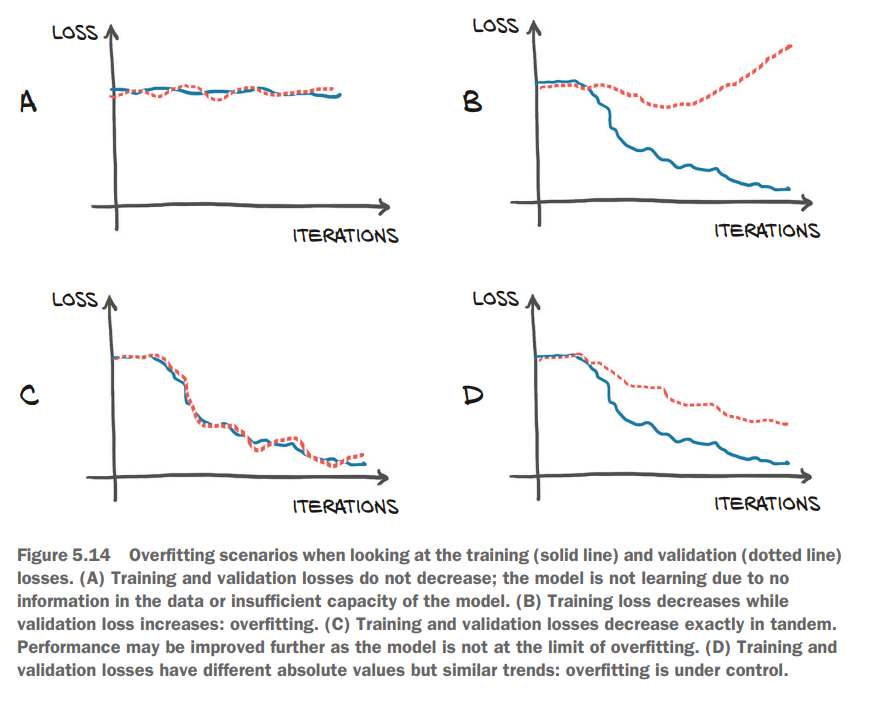

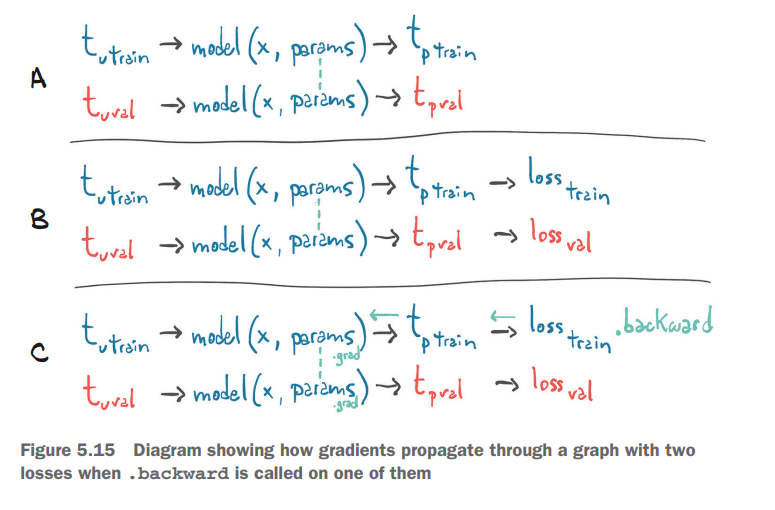

 There’s another element for discussion here. Since we’re not ever calling backward on val_loss, why are we building the graph in the first place? We could in fact
just call model and loss_fn as plain functions, without tracking the computation.
However optimized, building the autograd graph comes with additional costs that we
could totally forgo during the validation pass, especially when the model has millions
of parameters.
 In order to address this, PyTorch allows us to switch off autograd when we don’t
need it, using the torch.no_grad context manager.12 We won’t see any meaningful
advantage in terms of speed or memory consumption on our small problem. However, for larger models, the differences can add up. We can make sure this works by
checking the value of the requires_grad attribute on the val_loss tensor:

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
train_t_c, val_t_c):
  for epoch in range(1, n_epochs + 1):
    train_t_p = model(train_t_u, *params)
    train_loss = loss_fn(train_t_p, train_t_c)

    with torch.no_grad():
      val_t_p = model(val_t_u, *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

Using the related set_grad_enabled context, we can also condition the code to run
with autograd enabled or disabled, according to a Boolean expression—typically indicating whether we are running in training or inference mode. We could, for instance,
define a calc_forward function that takes data as input and runs model and loss_fn
with or without autograd according to a Boolean train_is argument:

In [62]:
def calc_forward(t_u,t_c,is_train):
  with torch.set_grad_enabled(is_train):
    t_p = model(t_u,*params)
    loss = loss_fn(t_p,t_c)
  return loss

## Exercise

In [73]:
def model(t_u,w2,w1,b):
  return w2*t_u**2 + w1*t_u + b

In [76]:
import torch.optim as optim

In [77]:
params = torch.tensor([1.0,1.0,0],requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params],lr=learning_rate)

In [79]:
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

Epoch 1, Training loss 757.6071, Validation loss 307.6372
Epoch 2, Training loss 734.1652, Validation loss 300.2998
Epoch 3, Training loss 711.1042, Validation loss 293.0575
Epoch 500, Training loss 4.1459, Validation loss 19.8455
Epoch 1000, Training loss 3.1105, Validation loss 14.3949
Epoch 1500, Training loss 2.6248, Validation loss 10.5229
Epoch 2000, Training loss 2.4914, Validation loss 8.4672
Epoch 2500, Training loss 2.4639, Validation loss 7.5914
Epoch 3000, Training loss 2.4502, Validation loss 7.2440


tensor([ 0.5030, -0.1997, -2.7552], requires_grad=True)